In [1]:
# %pip install nltk
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install tensorflow

In [1]:
import re
import nltk
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D

In [2]:
nltk.download('stopwords')

from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [3]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime2.xlsx")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68935 entries, 0 to 68934
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   68935 non-null  object
 1   Label   68935 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None


In [4]:
print(train_df.describe())

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               68935  68935
unique                                              68394      2
top     Don’t want to play the friend who drives hero ...  Crime
freq                                                    2  35335
All entries unique: False
Null cells: 0


In [5]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

All entries unique: True
Null cells: 0


In [6]:
def preprocess_x(data, get_word_count = False, single_entry=False):
    text_list = []
    word_count = []

    if not single_entry:
        for entry in data:
            new_text = re.sub("[^a-zA-Z ]", " ", entry)
            new_text = [word for word in new_text.lower().split() if word not in STOPWORDS]
            word_count.append(len(new_text))
            new_text = ' '.join(new_text)
            text_list.append(new_text)
    else:
        new_text = re.sub("[^a-zA-Z ]", " ", data)
        new_text = [word for word in new_text.lower().split() if word not in STOPWORDS]
        word_count.append(len(new_text))
        new_text = ' '.join(new_text)
        text_list.append(new_text)
    
    if get_word_count:
        return text_list, word_count
    else:
        return text_list

In [7]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count', 'label_name'])

filtered_df['label_name'] = pd.Series(pd.Categorical(train_df['Label']))
filtered_df['label'] = (pd.Categorical(filtered_df['label_name']).codes).astype(int)
label_ids = dict(enumerate(filtered_df['label_name'].cat.categories))

print("Label IDs")
print(label_ids)

filtered_df['text'], filtered_df['word_count'] = preprocess_x(train_df['Title'], get_word_count=True)
filtered_df = filtered_df[filtered_df['word_count']>2]
print(filtered_df.head())

Label IDs
{0: 'Crime', 1: 'Non-Crime'}
                                                text  label  word_count  \
0  villager murdered chhattisgarh police suspect ...      0           7   
1  maha nigerian man wanted drugs case found dead...      0          10   
2           delhi police arrests absconding criminal      0           5   
3            ott show undercover op cop life journey      0           7   
4  internet services suspended days manipur secti...      0           7   

  label_name  
0      Crime  
1      Crime  
2      Crime  
3      Crime  
4      Crime  


Crime        35335
Non-Crime    33059
Name: Label, dtype: int64


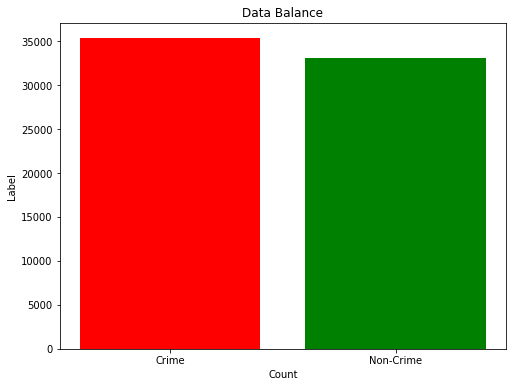

Average Word count: 9.086918903064966
        Max Word Count: 24
        Min Word Count: 3


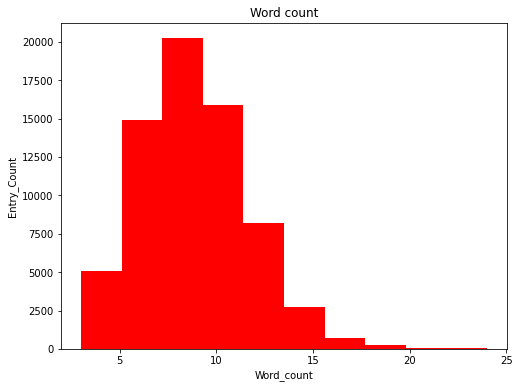

In [8]:
label_counts = train_df['Label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

print(f'Average Word count: {np.average(filtered_df["word_count"])}\n\
        Max Word Count: {max(filtered_df["word_count"])}\n\
        Min Word Count: {min(filtered_df["word_count"])}')

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['word_count'],color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [10]:
MAX_NB_WORDS = 40000
MAX_SEQUENCE_LENGTH = max(filtered_df["word_count"])
EMBEDDING_DIM = 100
TRUNC_TYPE= 'post'
PADDING_TYPE = 'post'
OOV_TOK= '<OOV>'
TEST_SIZE = 0.4
VALIDATION_SIZE = 0.1
LR = 0.001
DECAY = 1e-6
NUM_EPOCH = 5

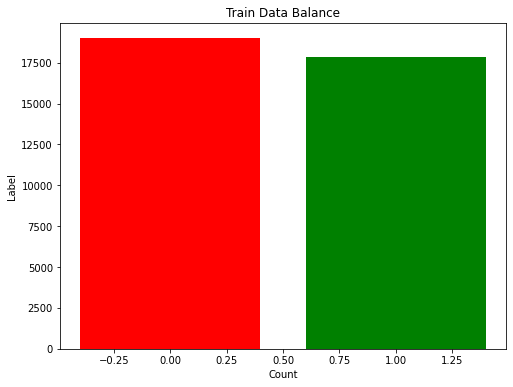

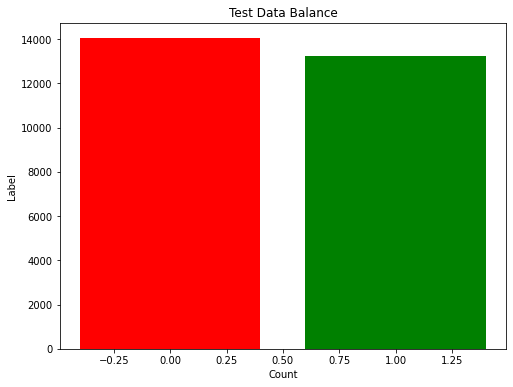

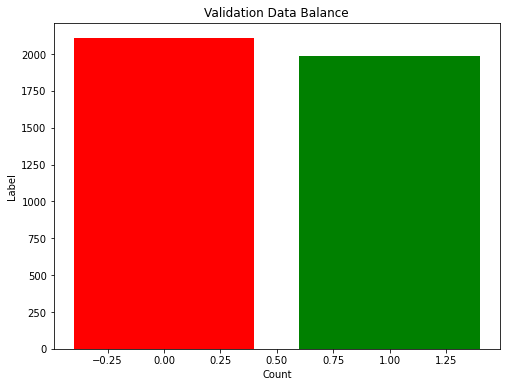

In [11]:
x_train_val,x_test,y_train_val,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=TEST_SIZE,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y_train_val, test_size=VALIDATION_SIZE,shuffle=True)

train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

plt.figure(figsize=(8, 6))
plt.bar(train_label_counts.index, train_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Train Data Balance')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(test_label_counts.index, test_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Test Data Balance')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(val_label_counts.index, val_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Validation Data Balance')
plt.show()

In [31]:
def tokenise(tokenizer, data, maxlen=MAX_SEQUENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE):
    data_sequences = tokenizer.texts_to_sequences(data)
    data_padded = pad_sequences(data_sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    return data_padded

In [32]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, oov_token=OOV_TOK)
tokenizer.fit_on_texts(filtered_df['text'])
print(f'Total Entries/Tweets: {len(filtered_df)}\n\
        Total Tokens: {len(tokenizer.word_index)}\n\
        Token Limit: {MAX_NB_WORDS}')

x_train_padded = tokenise(tokenizer, x_train)
x_test_padded = tokenise(tokenizer, x_test)
x_val_padded = tokenise(tokenizer, x_val)

Total Entries/Tweets: 68190
        Total Tokens: 36342
        Token Limit: 40000


In [15]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         4000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 4,161,202
Trainable params: 4,161,202
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = Adam(learning_rate=LR, decay=DECAY)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

history = model.fit(
    x_train_padded, y_train,
    epochs=NUM_EPOCH,
    # validation_split=0.1,
    validation_data=(x_val_padded, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
    verbose=2)

Epoch 1/5
1151/1151 - 86s - loss: 0.2949 - accuracy: 0.8725 - val_loss: 0.2701 - val_accuracy: 0.8873 - 86s/epoch - 74ms/step
Epoch 2/5
1151/1151 - 84s - loss: 0.1628 - accuracy: 0.9382 - val_loss: 0.2918 - val_accuracy: 0.8878 - 84s/epoch - 73ms/step
Epoch 3/5
1151/1151 - 84s - loss: 0.0946 - accuracy: 0.9665 - val_loss: 0.3727 - val_accuracy: 0.8778 - 84s/epoch - 73ms/step
Epoch 4/5
1151/1151 - 86s - loss: 0.0511 - accuracy: 0.9816 - val_loss: 0.4513 - val_accuracy: 0.8741 - 86s/epoch - 75ms/step


In [17]:
accr = model.evaluate(x_test_padded,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

853/853 [==============================] - 11s 13ms/step - loss: 0.4114 - accuracy: 0.8824
Test set
  Loss: 0.411
  Accuracy: 0.882


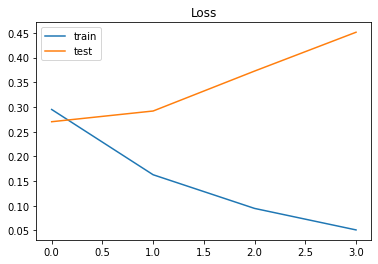

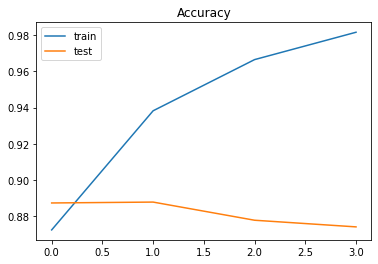

In [18]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [24]:
new_complaints = [
    "Government makes GST compulsory", 
    "Aviral commited theft by stealing my pen"
    ]
pre_complaint = preprocess_x(new_complaints)
print(pre_complaint)
print(tokenizer.texts_to_sequences(pre_complaint))
padded = tokenise(tokenizer, pre_complaint)
pred_list = model.predict(padded)
for pred in pred_list:
    print(pred,np.argmax(pred),label_ids[np.argmax(pred)])

['government makes gst compulsory', 'aviral commited theft stealing pen']
[[183, 291, 530, 10683], [1, 1, 590, 730, 3438]]
[0.5622766  0.43772337] 0 Crime
[0.9988199  0.00118006] 0 Crime
